# **PSET 3**

 These are some of the libraries/modules you will require for this homework.

In [7]:
# Install OpenCV version 4.5.1.48 as it includes SIFT.
%pip install opencv-contrib-python==4.8.0.76

  Obtaining dependency information for opencv-contrib-python==4.8.0.76 from https://files.pythonhosted.org/packages/05/33/5a6436146bda09c69decc456cfb54f41d52fbcf558fe91e6df7bdde6cce0/opencv_contrib_python-4.8.0.76-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import copy
import os
import random

import numpy as np
import scipy
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

These are some functions which will be useful throughout the homework for visualizations.

In [2]:
def display_color(x: np.array, normalized:bool = False):
    plt.figure(figsize=(10,10))
    if not normalized:
        plt.imshow(x,vmin=0,vmax=1)
    else:
        plt.imshow(x/x.max(),vmin=0,vmax=1)
    return plt

In [3]:
def plot_correspondences(image1, image2, correspondences, color):
    image = np.concatenate((image1, image2), axis=1)
    for correspondence in correspondences:
        point1, point2 = correspondence
        point1 = (int(round(point1[0])), int(round(point1[1])))
        point2 = (int(round(point2[0])), int(round(point2[1])))
        cv2.circle(image, point1, 10, color, 2, cv2.LINE_AA)
        cv2.circle(image, tuple([point2[0] + image1.shape[1], point2[1]]), 10, 
                   color, 2, cv2.LINE_AA)
        cv2.line(image, point1, tuple([point2[0] + image1.shape[1], point2[1]]), 
                 color, 2)
    plot = display_color(image)
    return plot

# Question 3

### Image Stitching

In this question, you will be stitching together two images of the same scene (images assumed to be in left to right order) taken from different camera viewpoints to form a panorama of the scene. This task will require implementing a pipeline with the following steps:

1. Extract SIFT keypoints and descriptors from each image and propose possible correspondences by matching SIFT descriptors between the two images. Note that this step outputs some false correspondences, which will be pruned in the next step.
2. Estimate the homography between the two images using the following RANSAC loop:

```
For N iterations:
    i. Get random subset of correspondences.
    ii. Compute the homography H using homogeneous direct linear transform (DLT) applied to the random subset of correspondences.
    iii. Count the number of inliers, where inliers are the correspondences (in the whole set of correspondences) that the homography 
    fits well (using Euclidean distance as the error metric).
    iv. Keep the homography H with the largest number of inliers and H's corresponding set of inliers.
```

3. Recompute the homography H using the set of inliers from step 2.
4. Use the homographies obtained from step 3 to stitch together the images to form a panorama.

Load the two images to be stitched together.

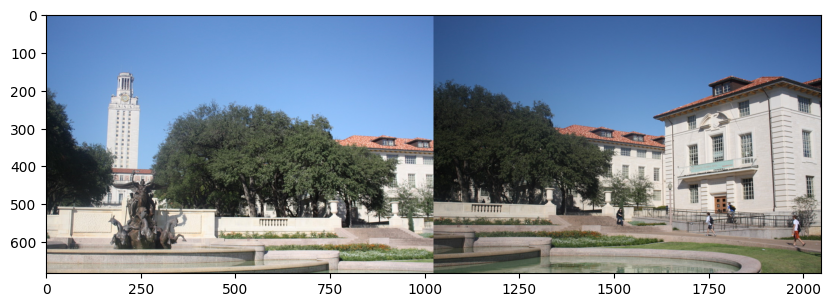

In [6]:
image1 = np.asarray(Image.open('Data/Problem_3/uttower_left.jpg'))
image2 = np.asarray(Image.open('Data/Problem_3/uttower_right.jpg'))
plot = display_color(np.concatenate((image1, image2), axis=1))

#### **Answer 3.1**

The first step of image stitching is to obtain SIFT keypoints and descriptors for each image. Complete the function ```run_sift(image, num_features)``` that returns the SIFT keypoints and descriptors for a color image ```image```; ```num_features``` is a parameter that limits the number of SIFT keypoints and descriptors the function should return. Note that you will need to convert the image to grayscale before running SIFT. *Hint*: OpenCV has functions to convert an RGB image to grayscale and to compute SIFT keypoints and descriptors given a grayscale image.

Copy paste your solution in the cell below on Overleaf for Question 3.1.

In [7]:
# The image stitching: first to obtain the sift
# run the func to obtain the sift

# Write your code in this cell.

def run_sift(image, num_features):
    # step1: rgb2gray convert to gray scale
    gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # step2: cv2.SIFT_create; use this func to get the SIFT
    sift = cv2.SIFT_create(num_features)
    
    # sift = cv2.SIFT_create(num_feature)  input for function <=> input for SIFT
    # check the usage of cv2.SIFT_create by youself
    [keypoint_, descriptor_] = sift.detectAndCompute(gray_image, None)
    kp_coord = np.zeros([num_features,2])
    
    for i in range(len(keypoint_)):
        # cv2.pt use format as [col, row]
        kp_coord[i] = keypoint_[i].pt
    
    # step3: return keypoints and descriptors
    return kp_coord, descriptor_

#### **Answer 3.2**

After computing the SIFT keypoints and descriptors, you will then need to match SIFT descriptors between the two images to obtain a set of possible correspondences. To obtain these correspondences, you should follow the steps below as proposed in the SIFT paper (Lowe 2004):

```
For every keypoint kp in the first image, 

1. Find the two keypoints kp1, kp2 in the second image with descriptors des1, des2 that are closest and second closest, respectively, 
to the descriptor des of the first image's keypoint. The distance metric is Euclidean distance d(x, y).
2. Add (kp, kp1) as a possible correspondence if d(des, des1) < ratio * d(des, des2), where ratio is a parameter of the algorithm. 
The idea here is that you want the descriptor des1 in the second image to be much closer to the descriptor des in the first image 
than any other descriptor in the second image.
```
Complete the function ```find_sift_correspondences(kp1, des1, kp2, des2, ratio)``` that returns a list of possible correspondences given SIFT keypoints ```kp1, kp2``` and descriptors ```des1, des2``` from the two images and the parameter ```ratio```.

Copy paste your solution in the cell below on Overleaf for Question 3.2.

In [8]:
# Write your code in this cell.
    
def find_sift_correspondences(kp1, des1, kp2, des2, ratio):
    # Hint: follow the instructions
    # Have the descriptors and the ratio
    # Ratio is for the ratio test; If ratio test is satisfied, add the keypoints correspondence
    
    img_match = []
    
    for i in range(len(des1)):
        # step1: Compute the pairwise distance between all descriptors in the 1st image and all descriptors in the 2nd image 
        # initialize the two baseline minimum distance
        dist_min1 =  np.linalg.norm(des1[i] - des2[0], ord=2)
        dist_min2 =  np.linalg.norm(des1[i] - des2[1], ord=2)
        dist_min1_pos = 0
        dist_min2_pos = 1
        
        if dist_min2 < dist_min1:
            dist_ = dist_min1
            dist_min1 = dist_min2
            dist_min2 = dist_
            dist_min1_pos = 1
            dist_min2_pos = 0
        
        for j in range(2, len(des2)):
            dist_ = np.linalg.norm(des1[i] - des2[j], ord=2)
            
            # step2: find indices of descriptors in the 2nd image that are closest to descriptors in the 1st image
            if dist_min1<dist_ and dist_<dist_min2:
                dist_min2 = dist_
                dist_min2_pos = j
            
            if dist_<dist_min1:
                dist_min2 = dist_min1
                dist_min2_pos = dist_min1_pos
                dist_min1 = dist_
                dist_min1_pos = j
                        
        # step3: use the ratio; for each descriptor in the 1st image, apply the ratio and test step 2
        #        if the ratio test is satisfied, then add correspondence in heterogeneous coordinates
        des1_des2_min1 = np.linalg.norm(des1[i] - des2[dist_min1_pos], \
                                        ord=2)
        des1_des2_min2 = np.linalg.norm(des1[i] - des2[dist_min2_pos], \
                                        ord=2)
        
        kp_match = [0,0]
        if  des1_des2_min1 < ratio * des1_des2_min2:
            kp_match[0] = kp1[i]
            kp_match[1] = kp2[dist_min1_pos]
            img_match.append(kp_match)
    
    # return the correspondences
    return img_match

#### **Answer 3.3**

Now that you have computed the possible correspondences, you can now visualize them. You should observe that there are many correspondences, some of which are quite noisy (you will observe this more clearly after implementing RANSAC).

Upload the saved image on Overleaf for Question 3.3.

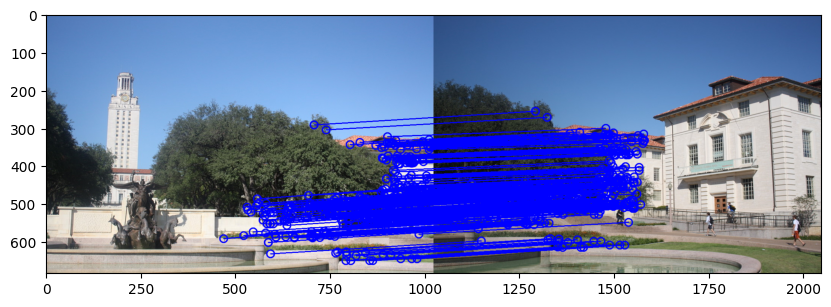

In [9]:
# Verify the correspondences between the two images
# Visualization between the 2 images (like Page 11, Lec11)

kp1, des1 = run_sift(image1, 2000)
kp2, des2 = run_sift(image2, 2000)
correspondences = find_sift_correspondences(kp1, des1, kp2, des2, 0.6)
plot = plot_correspondences(image1, image2, correspondences, (0, 0, 255))
os.makedirs('Data/Solutions', exist_ok=True)
plot.savefig('Data/Solutions/question_3_3.pdf', format='pdf', bbox_inches='tight')

#### **Answer 3.4**

After obtaining possible correspondences, you will need to use the RANSAC loop to prune the outlier correspondences. You will implement the RANSAC loop in parts. The first part is to compute the homography given a list of correspondences. Complete the function ```compute_homography(correspondences)``` that computes a homography matrix $H$ using homogeneous direct linear transform (DLT) given a list of correspondences (in heterogeneous coordinates).

Copy paste your solution in the cell below on Overleaf for Question 3.4.

In [10]:
# Write your code in this cell.

# We are given the correspondences
def compute_homography(correspondences):
    # step1: Use all the correspondences to construct coefficient matrix
    # Page 27 Lec 11; Write out Coeffcient Matrix A, follow the steps and solve for Homography Matrix h
    mat_A = np.zeros([1,9])
    
    for i in range(len(correspondences)):
        x = correspondences[i][0][0]
        y = correspondences[i][0][1]
        x_prime = correspondences[i][1][0]
        y_prime = correspondences[i][1][1]
        
        mat_A_correspond = [[-x, -y, -1, 0, 0, 0, \
                             x*x_prime, y*x_prime, x_prime],\
                            [0, 0, 0, -x, -y, -1, \
                             x*y_prime, y*y_prime, y_prime]]
        mat_A = np.vstack([mat_A, mat_A_correspond])
        
    mat_A = np.delete(mat_A, 0, 0)
    
    # step2: Compute the homography by SVD (numpy SVD), taking singular vector with minimum singular value, 
    #        and then reshape into Matrix (python reshape)
    #        np.linalg.svd
    u, s, vh = np.linalg.svd(mat_A)
    homography_mat = vh[8].reshape(3,3)
    #homography_mat = homography_mat/homography_mat[2,2]
    
    # return the homography matrix
    return homography_mat

#### **Answer 3.5**

In addition to computing a homography matrix $H$ given a list of correspondences, it is also useful to apply a homography to warp a list of 2D points. Complete the function ```apply_homography(points, homography)``` that applies a homography to warp a list of 2D points given in heterogeneous coordinates. The function should return a list of 2D points, also in heterogeneous coordinates.

*Hint*: You should convert the input 2D points into homogeneous coordinates before applying the homography. After applying the homography, you get the output 2D points in homogeneous coordinates, so you have to convert the output points back into heterogeneous coordinates.

Copy paste your solution in the cell below on Overleaf for Question 3.5.

In [11]:
# Write your code in this cell.

def apply_homography(points, homography):
    # Hint: follow the instruction
    
    # step1: convert input to homogeneous coordinates ([x,y] -> [x,y,1])
    homo_coord = [points[0], points[1], 1]
    
    # step2: apply the homography matrix in 3.4
    homo_warp = homography@homo_coord
    
    # step3: convert the output back to heterogenous coordinates
    heter_coord = [homo_warp[0]/homo_warp[2], homo_warp[1]/homo_warp[2]]
    
    return heter_coord

#### **Answer 3.6**

Another part of the RANSAC loop is determining the inliers, where inliers are the correspondences that the homography fits within a Euclidean distance threshold. Complete the function ```compute_inliers(homography, correspondences, threshold)``` that returns the list of inliers and the list of outliers given a homography matrix, a set of potential correspondences, and a distance threshold.

Copy paste your solution in the cell below on Overleaf for Question 3.6.

In [12]:
# Write your code in this cell.

def compute_inliers(homography, correspondences, threshold):
    # Hint: Page 27 Lec 11
    # Have the homography and correspondences, want to set a threshold(constraints) to get the inliers
    # Don't want to get sth too far away from inlier
    
    inliers = []
    outliers = []

    for i in range(len(correspondences)):
        # step1: get points from correspondences corresponding to the 1st and 2nd images -> list of points1 and points2
        kp1_coord = correspondences[i][0]
        kp2_coord = correspondences[i][1]
        
        # step2: apply the homography to points in the 1st image 
        homo_warp = apply_homography(kp1_coord, homography)
    
        # step3: compute the squared error between points in the second image and the warped points(output of step2)
        dist_ = np.linalg.norm(kp2_coord - homo_warp, ord=2)
        
        # step4: based on the squared distance, you have the threshold, and then you can return the inliers and outliers
        #        based on the theshold
        if dist_<=threshold:
            inliers.append([kp1_coord, kp2_coord]) 
        
        if dist_>threshold:
            outliers.append([kp1_coord, kp2_coord]) 
 
    return inliers, outliers

#### **Answer 3.7**

Now that you have implemented functions to compute a homography matrix and its inliers, you can now implement the RANSAC loop. Complete the function ```ransac(correspondences, num_iterations, num_sampled_points, threshold)```, which runs the RANSAC loop to return a homography matrix with its corresponding sets of inliers and outliers. The parameters to the function are the set of possible correspondences, the number of iterations, the number of correspondences to sample for each iteration, and the inliers distance threshold.

Copy paste your solution in the cell below on Overleaf for Question 3.7.

In [13]:
# Write your code in this cell.

def ransac(correspondences, num_iterations, num_sampled_points, threshold):
    # Combine all previous steps
    # implement RANSEC
    num_in = 0
    sel_in = []
    sel_out = []
    sel_H = []
    
    for i in range(num_iterations):
        selected_kp_match = random.choices(correspondences, \
                                           k=num_sampled_points)
        H = compute_homography(selected_kp_match)
        in_, out_ = compute_inliers(H, correspondences, threshold)
        current_in = len(in_)
        
        # retrieve the H with most inliers
        if current_in>num_in:
            num_in = current_in
            sel_in = in_
            sel_out = out_
            sel_H = H
        
    #return homography, inliers_arr, outliers_arr
    return sel_H, sel_in, sel_out

In [ ]:
"""
# In Lecture Ransec

def find_H(correspondences):
    num_inlier = 0
    H_result = np.zeros([3,3])
    while(num_inlier < 0.5*len(correspondences)):
        selected_kp_match = random.choices(correspondences, k=6)
        H = compute_homography(selected_kp_match)
        warp_result = compute_inliers(H, correspondences, 3)
        in_ = warp_result[0]
        num_inlier = len(in_)
        
    return H, in_

ransac_H = find_H(correspondences)[0]
inlier_kp = find_H(correspondences)[1]
new_H = compute_homography(inlier_kp)
H_inv = np.linalg.inv(new_H)

image2_out = cv2.warpPerspective(image2,H_inv,(1750, 1750),flags=cv2.INTER_LINEAR)
plot = display_color(image2_out)
"""

#### **Answer 3.8**

You will now visualize the inlier (first image in green) and outlier (second image in red) correspondences returned by RANSAC. Note that some of the outliers are quite noisy.

Execute the cell below and copy the saved images on Overleaf for Question 3.8.

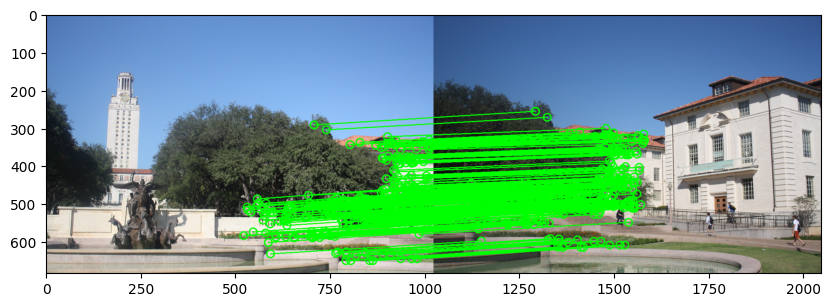

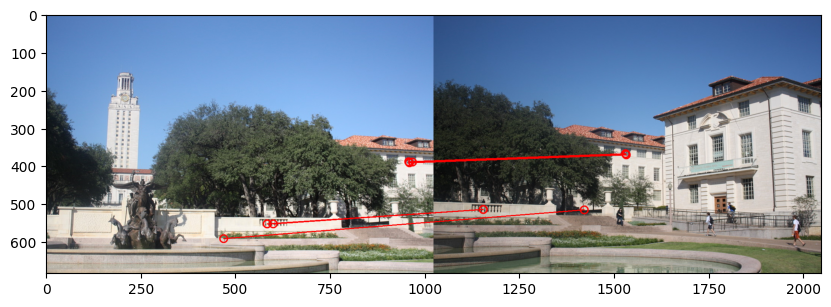

In [14]:
# Verify inliers and outliers (Lec 11 window image)
# green-line: inliers.
# red-line: outliers
# more inliers than outliers
H, inliers, outliers = ransac(correspondences, 50, 6, 3)
inliers_plot = plot_correspondences(image1, image2, inliers, (0, 255, 0))
inliers_plot.savefig('Data/Solutions/question_3_8_inliers.pdf', format='pdf', bbox_inches='tight')
outliers_plot = plot_correspondences(image1, image2, outliers, (255, 0, 0))
outliers_plot.savefig('Data/Solutions/question_3_8_outliers.pdf', format='pdf', bbox_inches='tight')


#### **Answer 3.9**

The final portion that needs to be implemented is the actual stitching of the two images given the homography $H$ from the first image to the second image. For the stitching process, you should apply inverse warping to warp the second image to the viewpoint of the first image. The inverse warping works as follows:
1. Find where pixels ```p1``` in the first image (output image) are warped to in the second image (input image) when applying the homography $H$. Note that the homography $H$ itself is the inverse transform as you are currently trying to warp the second image to the first image, which would use homography $H^{-1}$. Let ```p2``` be the corresponding pixel location in the second image.
2. Assuming that ```p2``` is in the second image, the pixel locations ```p2``` may not be integer locations. Apply bilinear interpolation to compute the pixel value of the second image at location ```p2```.

As bilinear interpolation is needed for the inverse warping, complete the function ```interpolate(image, loc)``` that implements bilinear interpolation to compute the pixel value in the image corresponding to a pixel location. 

Bilinear interpolation works as follows; for a given location $(x + \Delta x, y + \Delta y)$, where $x, y$ are integers and $0 \leq \Delta x, \Delta y < 1$, we consider the four neighboring integer pixel locations $(x, y), (x + 1, y), (x, y + 1), (x + 1, y + 1)$ and then perform multiple linear interpolations (it may help to take a look at lecture 8 slide 68 for some diagrams):

1. Compute pixel value $I(x + \Delta x, y)$: $I(x + \Delta x, y) = I(x, y) (1 - \Delta x) + I(x + 1, y) \Delta x $.
2. Compute pixel value $I(x + \Delta x, y + 1)$: $I(x + \Delta x, y + 1) = I(x, y + 1) (1 - \Delta x) + I(x + 1, y + 1) \Delta x $.
3. Compute pixel value $I(x + \Delta x, y + \Delta y)$: $I(x + \Delta x, y + \Delta y) = I(x + \Delta x, y) (1 - \Delta y) + I(x + \Delta x, y + 1) \Delta y$.

Substituting the first two steps into the last step, the following formula for bilinear interpolation is obtained:

$I(x + \Delta x, y + \Delta y) = I(x, y)(1 - \Delta x)(1 - \Delta y) + I(x + 1, y)\Delta x(1 - \Delta y) + I(x, y + 1)(1 - \Delta x)\Delta y + I(x + 1, y + 1)\Delta x \Delta y$.

Copy paste your solution in the cell below on Overleaf for Question 3.9.

In [15]:
# Write your code in this cell.

def interpolate(image, loc):
    # Hint: implement based on points 1-3
    x_loc = loc[0]
    y_loc = loc[1]
    x = int(np.floor(x_loc))
    delta_x = x_loc-x
    y = int(np.floor(y_loc))
    delta_y = y_loc-y
    
    if x>=0 and x<=image.shape[0]-2 and y>=0 and y<=image.shape[1]-2:
        I_x_delta_x_y = (image[x][y])*(1-delta_x) + \
                        (image[x+1][y])*delta_x
        
        I_x_delta_x_y_1 = (image[x][y+1])*(1-delta_x) + \
                          (image[x+1][y+1])*delta_x
        
        I_x_delta_x_y_delta_y = I_x_delta_x_y*(1-delta_y) + \
                                I_x_delta_x_y_1*delta_y
        
    else:
        I_x_delta_x_y_delta_y = [0, 0, 0]

    return I_x_delta_x_y_delta_y

#### **Answer 3.10**

Now that you have implemented bilinear interpolation, you can implement a function to actually stitch the two images together. Complete the function ```stitch_image_given_H(image1, image2, homography)``` that stitches ```image1``` and ```image2``` together and returns the stitched image given a homography matrix from ```image1``` to ```image2```. This function should apply inverse warping as described above. For this function, you can assume that ```image1``` is to the left of ```image2```; if a pixel location in the stitched image belongs to both images, you can average the corresponding pixel values from both images.

Copy paste your solution in the cell below on Overleaf for Question 3.10.

In [16]:
# Write your code in this cell.

def stitch_image_given_H(image1, image2, homography):    
    # combine previous steps
    # see the stitched image
    I_inverse_warp = np.zeros([image1.shape[0], 2*image1.shape[1], 3])
    
    #warp img2 to the same perspective as img1
    #flip x-y coord. as cv2 returns points as [col, row]
    for i in range(I_inverse_warp.shape[0]):
        for j in range(I_inverse_warp.shape[1]):
            p2_coord = apply_homography([j,i], homography)
            I_inverse_warp[i][j] = interpolate(image2, [p2_coord[1], \
                                                        p2_coord[0]])
                
    #stitch image together
    stitch_img =  np.zeros([image1.shape[0], 2*image1.shape[0], 3])

    for i in range(stitch_img.shape[0]):
        for j in range(stitch_img.shape[1]):
            
            #may contain overlapping regions between img1 & warped_img2
            if j>=0 and j<=image1.shape[1]-1:
                
                #average between overlapping pixels if the pixel from warped_img2 has a value
                if I_inverse_warp[i][j][0]!=0 and \
                   I_inverse_warp[i][j][1]!=0 and \
                   I_inverse_warp[i][j][2]!=0:
                    
                    stitch_img[i][j] = [(float(I_inverse_warp[i][j][0])+\
                                         float(image1[i][j][0]))/2, \
                                        (float(I_inverse_warp[i][j][1])+\
                                         float(image1[i][j][1]))/2, \
                                        (float(I_inverse_warp[i][j][2])+\
                                         float(image1[i][j][2]))/2]
                
                #warped_img2 has no value (black), just use img1 pixel value
                else:
                    stitch_img[i][j] = image1[i][j]
            
            #far right region with just warped_img2
            else:
                stitch_img[i][j] = I_inverse_warp[i][j]

    return stitch_img


In [ ]:
"""
# inverse warp using cv2 library

image2_out = cv2.warpPerspective(image2,new_H,(2*image1.shape[1], image1.shape[0]),flags=cv2.WARP_INVERSE_MAP)
plot = display_color(image2_out)
"""

#### **Answer 3.11**

Now, you have implemented all the parts of the image stitching pipeline. Put it all together and complete the function ```stitch_image(image1, image2, num_features, sift_ratio, ransac_iter, ransac_sampled_points, inlier_threshold, use_ransac)``` that stitches two images together given various parameters of the algorithm (number of SIFT features, ratio for obtaining initial SIFT correspondences, RANSAC parameters, whether to use RANSAC). *Reminder*: after you get the list of inliers with RANSAC, you should recompute the homography using this set of inliers.

Copy paste your solution in the cell below on Overleaf for Question 3.11.

In [17]:
# Write your code in this cell.

def stitch_image(image1, image2, num_features, sift_ratio, ransac_iter, \
                 ransac_sampled_points, inlier_threshold, use_ransac=True):
    
    kp1, des1 = run_sift(image1, num_features)
    kp2, des2 = run_sift(image2, num_features)
    correspondences = find_sift_correspondences(kp1, des1, \
                                                kp2, des2, sift_ratio)
    
    if use_ransac == True:
        _, inliers, _ =  ransac(correspondences, ransac_iter, \
                                ransac_sampled_points, inlier_threshold)
        
        new_H = compute_homography(inliers)
        stitch_img = stitch_image_given_H(image1, image2, new_H)
    else:
        H = compute_homography(correspondences)
        stitch_img = stitch_image_given_H(image1, image2, H)
        
    return stitch_img

#### **Answer 3.12**

Execute the cell below and copy the saved image on Overleaf for Question 3.12. The cell runs the image stitching function to stitch the two sample images together (assuming that they are in left to right order). It is expected that there will be a small part of the image that is black. *Note:* This cell may take up to a few minutes to execute.

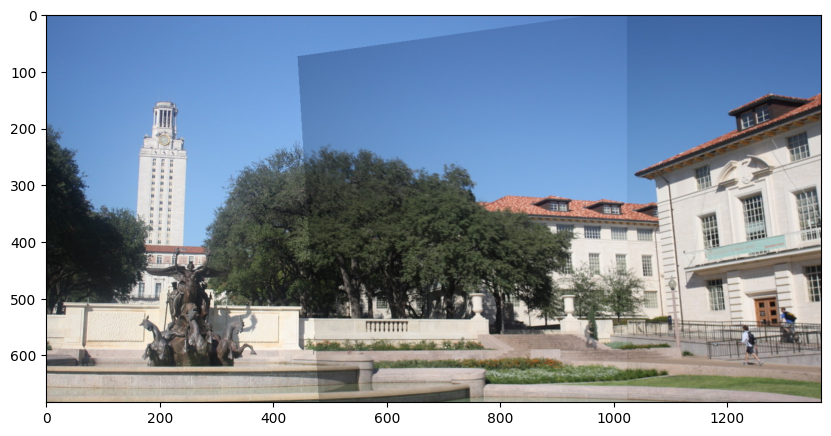

In [18]:
# The black part is a region of the stitched image that does not come from the two original images.
stitched_image = stitch_image(image1, image2, 2000, 0.6, 50, 6, 3)
stitched_plot = display_color(stitched_image / 255.0)
stitched_plot.savefig('Data/Solutions/question_3_12.pdf', format='pdf', bbox_inches='tight')

#### **Answer 3.13**

Execute the cell below and copy the saved image on Overleaf for Question 3.13. The cell runs the image stitching function to stitch the two sample images together (assuming that they are in left to right order) without filtering out outlier correspondences using RANSAC. You should observe that without RANSAC, the stitching does not work properly, showing the importance of RANSAC in the image stitching pipeline. *Note:* This cell may take up to a few minutes to execute.

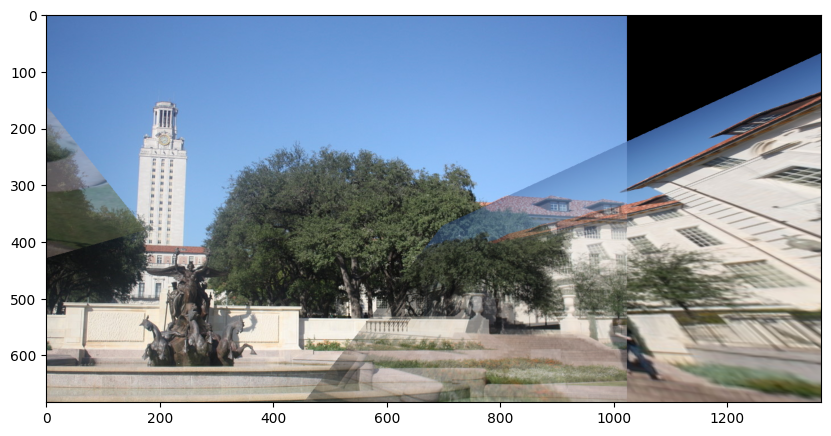

In [19]:
# The black part is a region of the stitched image that does not come from the two original images.
stitched_image = stitch_image(image1, image2, 2000, 0.6, 50, 6, 3, False)
stitched_plot = display_color(stitched_image / 255.0)
stitched_plot.savefig('Data/Solutions/question_3_13.pdf', format='pdf', bbox_inches='tight')

# Question 4

### Olympic Champion Using Homography

In this question, you will be making yourself the new World Swimming Champion using homography.

You are given the following image from the London 2012 Olympics. 

(339, 615, 3)

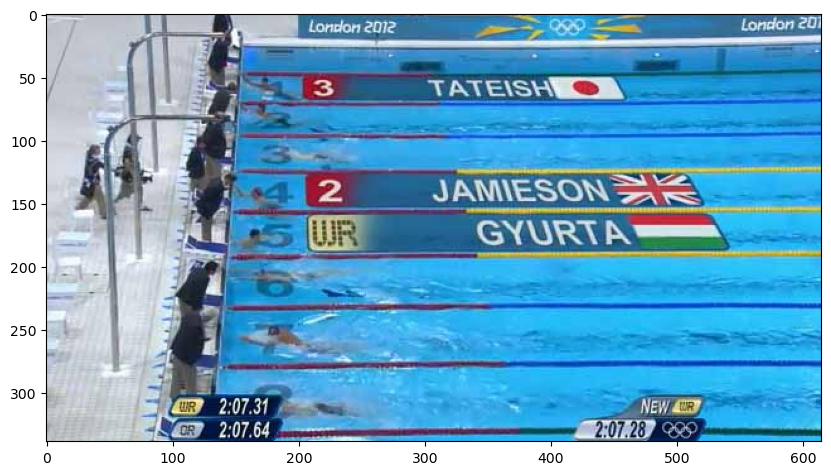

In [24]:
img = np.asarray(Image.open('Data/Problem_4/pool-vfx.jpg'))
_ = display_color(img/255.0)
img.shape

You have to use homography to make yourself the new World Champion:

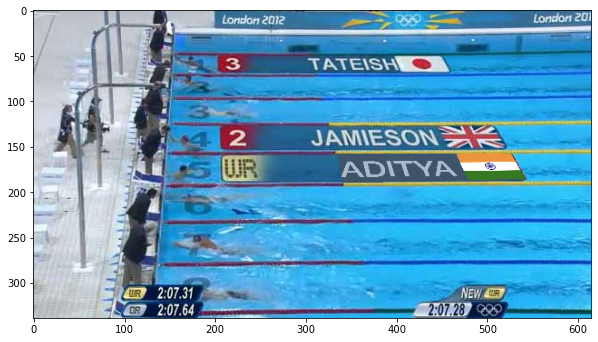

In [25]:
img_final = Image.open('Data/Problem_4/question_4.png')
display(img_final)

In the previous question, you used homography to stitch two images. You will use many functions from the previous question for this question. In the previous question, you used SIFT to compute the correspondences between the two images. Here you will estimate the corresponding points manually to construct the homography matrix and create the new image.

You will need two images for this question: (1) the pool image which we have provided, (2) an image with your name and country flag. To get an image with your name and flag, you are free to choose any method you want. In the example above, we used Keynote (on Mac) + Screenshot to get that image.

(771, 2162, 3)

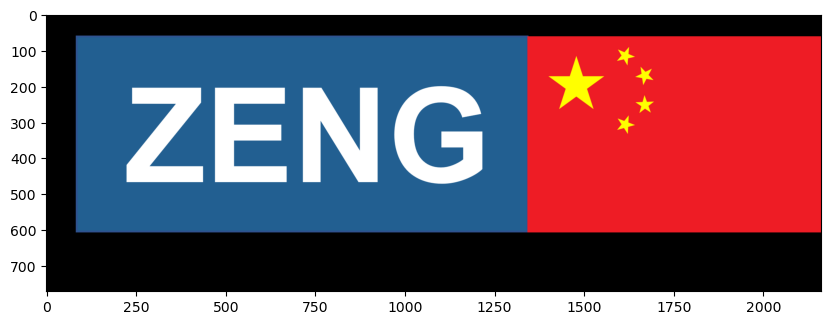

In [26]:
# Load your name+flag image here. You are free to choose any logo you want; we just provided a flag as an example.
name_img = np.asarray(Image.open('Data/Problem_4/name_image.png').convert('RGB'))
my_own_img = Image.open('Data/Problem_4/name_image.png').convert('RGB')
display_color(my_own_img)
name_img.shape

In the previous question, you used SIFT to compute the corresponding points. For this question, we have provided you with 4 points which should correspond to the 4 corners of your name+flag image.

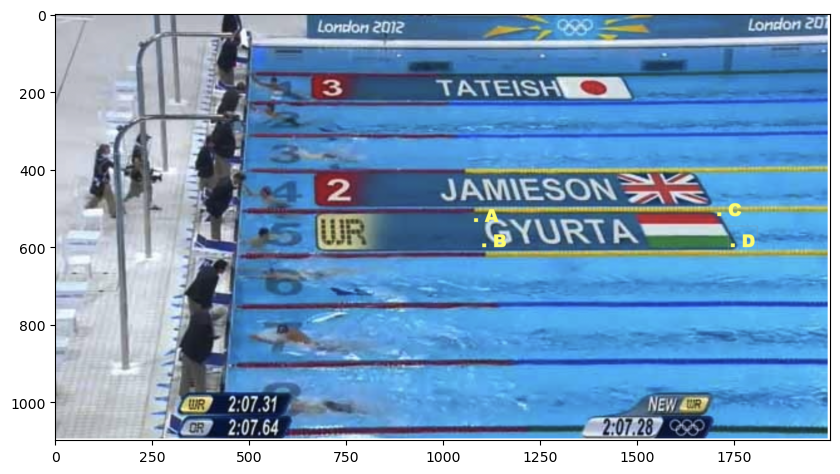

In [27]:
# corresponding points are provided
# 4 key points ABCD
# xy coord. with respect to image coord. displayed above

cp = np.asarray(Image.open('Data/Problem_4/Corresponding_points.png'))
_ = display_color(cp/255.0)

The $(x, y)$ coordinates for points $A, B, C, D$ in the above image, which will correspond to the 4 corners of your name+flag image, are provided below. For these $(x, y)$ coordinates, the positive x direction is along the right, the positive y direction is along the bottom, and the origin is the top left pixel of the image.

$(x,y)$ coordinates of the 4 points:
$A = (334, 158)$
$B = (340, 190)$
$C = (528, 157)$
$D = (545, 187)$

#### **Answer 4.1**

Fill in the values for the points corresponding to $A, B, C, D$ in your name+flag image. Copy the below cell on Overleaf for Question 4.1.

In [28]:
# Fill in the values for the corresponding points for your name+flag image.
# like before in cv2 use format [col, row]

A_1 = [125, 50]
B_1 = [125, 550]
C_1 = [2160, 50]
D_1 = [2160, 550]
correspondence = [
                  ([334,158], A_1),
                  ([340,190], B_1),
                  ([528,157], C_1),
                  ([545,187], D_1),
]

Using the 4 correspondences, you can construct the homography matrix.

In [29]:
homography = compute_homography(correspondence)

Now, you will need to stitch the name+flag image into the original Olympic pool image. Complete the function ```stitch_image_given_H_new(pool_image, name_flag_image)``` for this task, which stitches the name+flag image into the original Olympic pool image. Copy paste your solution in the cell below on Overleaf for Question 4.2.

This function should be similar to the stitching function you wrote previously with minor differences: (1) Previously, since you had to stitch two images side by side, the output image had twice the number of columns as the original image. For this question, since you will be stitching the name+flag image inside the pool image, the output image will have the same number of columns as the input pool image. In other words the output will have the same dimension as `pool_image`. (2) If a pixel location in the stitched image is valid in `pool_image` and has a valid inverse-warped pixel location in `name_flag_image`, then you will use the pixel value from `name_flag_image` instead of averaging both images' pixel locations.

#### **Answer 4.2**

In [30]:
# Write your code in this cell.
# key portion for this question

def stitch_image_given_H_new(pool_image, name_flag_image, homography):
    # Hint: make sure that stitched image has the same size as the pool image
    # step1: fill stitched image with pool image input
    I_inverse_warp = np.zeros([pool_image.shape[0], \
                               pool_image.shape[1], 3])
    
    # step2: apply inverse warping
    #warp img_name to the same perspective as img_pool
    for i in range(I_inverse_warp.shape[0]):
        for j in range(I_inverse_warp.shape[1]):
            p2_coord = apply_homography([j,i], homography)
            I_inverse_warp[i][j] = interpolate(name_flag_image, \
                                               [p2_coord[1], p2_coord[0]])
        
    #stitch image together
    stitch_img =  np.zeros([pool_image.shape[0], pool_image.shape[1], 3])

    for i in range(stitch_img.shape[0]):
        for j in range(stitch_img.shape[1]):

            if I_inverse_warp[i][j][0]!=0 and \
               I_inverse_warp[i][j][1]!=0 and \
               I_inverse_warp[i][j][2]!=0:
                
                    stitch_img[i][j] = I_inverse_warp[i][j]
        
            else:
                stitch_img[i][j] = pool_image[i][j]
    
    #return stitched_image
    return stitch_img

#### **Answer 4.3**

Execute the cell below and copy the saved image on Overleaf for Question 4.3. The cell runs the new stitching function to stitch your name+flag image into the original Olympic pool image.

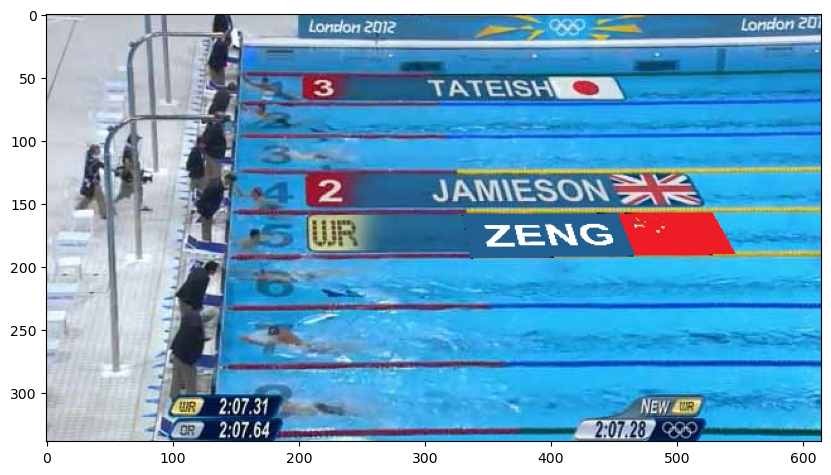

In [31]:
new_olympic_champion = stitch_image_given_H_new(img, name_img, homography) # apply name and flag to the pool image
plot = display_color(new_olympic_champion,True)
os.makedirs('Data/Solutions', exist_ok=True)
plot.savefig('Data/Solutions/question_4.png', format='png', bbox_inches='tight')

# Question 5

### Eight-Point Algorithm

In this question, you will use the eight-point algorithm to reconstruct 3D points associated with some correspondences between two images of the same scene. For this task, you will implement a pipeline with three broad steps:
1. Implement the eight-point algorithm to estimate the essential matrix.
2. Compute the translation and rotation between the cameras' coordinate frames using the essential matrix.
3. Reconstruct the 3D points by solving for their depths. Combining the depths with the 2D points will yield the reconstructed 3D points.

Load the correspondences. The correspondences are given as a list of tuples $((x_1, y_1), (x_2, y_2))$, where $(x_1, y_1)$ and $(x_2, y_2)$ are the corresponding points from the first and second image, respectively.

Page-98 Lec13

8 point algorithm review:
1. Have m matched image points {x_m, x'_m}; m=1,..,M
2. Epipolar geometry: each correspondence satisfies (x'_m.T)F(x_m) = 0; F as Fundamental Matrix
3. Solve for the 3*3 F Matrix -> Use SVD to solve for Ax = 0 form
   - Homogeneous linear system setup with 9 unknowns
   - write epipolar equation in x_m as 3 dimensional homogeneoud coord. & linear system form: 
   - (x'_m.T)*F*(x_m) = 0
   - x'_m.T = [x'_m, y'_m, 1]  (dimension: 1*3)
   - F = [[f1, f2, f3], [f4, f5, f6], [f7, f8, f9]]  (dimension: 3*3)
   - x_m = [[x_m],[y_m],[1]]  (dimension: 3*1)
   - 1 coorespondence gives ONE equations
   - f9 is the scaling factor, which is usually set to 1
   - We need 8Unknown/1 = at least 8 points to calculate the unknowns
4. The main factor: Calc for F, Fundamental Matrix

Implement 8 point algorithm:\
Step1: construct the M*9 matrix A \
Step2: find SVD of A \
Step3: F as the 2nd row/col of V.T in UD(V.T) that corresponds to the smallest singular value for a supposedly rank2 Matrix\
Step4: Enforce rank 2 constraints \
Step5: Unnormalize F

In [32]:
def format_correspondences(correspondences):
    formatted_corr = []
    for correspondence in correspondences:
        point1, point2 = correspondence[0:2], correspondence[2:]
        formatted_corr.append((point1, point2))
    return formatted_corr

In [33]:
correspondences = np.load('Data/Problem_5/correspondences.npy') # correspondences are provided. Directly get them
correspondences = format_correspondences(correspondences)

#### **Answer 5.1**

The first step for reconstructing the 3D points $X_1, X_2$ is to estimate the essential matrix using the eight-point algorithm. Complete the function ```compute_essential_matrix(correspondences)```, which returns the essential matrix given some correspondences using the algorithm in lecture 13. Copy paste your solution in the cell below on Overleaf for Question 5.1.

Assume that the essential matrix corresponds to rotating and translating the first image's camera frame to the second image's camera frame (i.e. $X_2=RX_1 + T$, where $R$ is the rotation matrix and $T$ is the translation vector). Enforce that the essential matrix $Q$ must be rank 2 by running SVD on it ($Q = U \Sigma V^T$), setting the smallest singular value of $Q$ to 0 to get a matrix $\Sigma'$ with the new singular values, and outputting the modified essential matrix $Q = U \Sigma' V^T$.

*Hint*: This process is similar to computing the homography between two images (question 3.4).

In [35]:
# Write your code in this cell.

def compute_essential_matrix(correspondences):
    # Hints similar to 3.4
    # In Q5.1
    # step1: create coefficient matrix
    mat_A = np.zeros([1,9])
    
    for i in range(len(correspondences)):
        x = correspondences[i][0][0]
        y = correspondences[i][0][1]
        x_prime = correspondences[i][1][0]
        y_prime = correspondences[i][1][1]
        
        mat_A_correspond = [x*x_prime, x*y_prime, x, y*x_prime, \
                            y*y_prime, y, x_prime, y_prime, 1]
        
        mat_A = np.vstack([mat_A, mat_A_correspond])
        
    mat_A = np.delete(mat_A, 0, 0)
    
    # step2: get the sigular vector of the coefficient matrix with the minimum singular value 
    u, s, vh = np.linalg.svd(mat_A)
    essential_mat = vh[8].reshape(3,3)
    # step3: enforce rank2 constraint on the essential matrix
    u_, sigma_, v_h = np.linalg.svd(essential_mat)
    essential_mat_rk2 = u_@\
                        [[sigma_[0], 0, 0], [0, sigma_[1], 0], [0, 0, 0]]\
                        @v_h
    
    # return essential matrix 
    return essential_mat_rk2

#### **Answer 5.2**

Now that you have computed the essential matrix, you can then compute the translation and rotation between the coordinate frames of both images' cameras. Complete the function ```compute_translation_rotation(essential_matrix)```, which returns the translation vector $T$, rotation matrix $R$, and $\hat{T}$ (the matrix associated with $T$) given the essential matrix $Q$. Copy paste your solution in the cell below on Overleaf for Question 5.2.

*Note:* Lecture 9 has a typo with the formula for the rotation matrix. The middle matrix in the formula should be transposed.

In [36]:
# Write your code in this cell.

def compute_translation_rotation(essential_matrix):
    # Hint: E = [t_x]*R
    # step1: E = U * Sigma * V^T <- SVD
    u, sigma, v_t = np.linalg.svd(essential_matrix)
    w = [[0, -1, 0], [1, 0, 0], [0, 0, 1]]
    
    # step2: R = ?
    R = u@w@v_t
    
    # step3: T_hat = t_x = (R^-1)*E = (R^T)*E 
    # R is an orthogonal matrix, (A^T)*A = A*(A^T) = I; A^T = A^-1
    t_x = u@w@[[sigma[0], 0, 0], [0, sigma[1], 0], [0, 0, sigma[2]]]@u.T

    # step4: Obtain T from T_hat
    T = [t_x[2, 1], t_x[0, 2], t_x[1, 0]]
    
    # return translation, rotation, t_hat
    return T, R, t_x

In [37]:
compute_essential_matrix(correspondences)

array([[-2.22726956e-03,  2.78124025e-02, -6.79757764e-03],
       [ 1.52935047e-01,  3.77777302e-03,  7.02666491e-01],
       [ 1.87732766e-02, -6.93819475e-01,  6.58135102e-04]])

In [38]:
T, R, t_x = compute_translation_rotation(compute_essential_matrix(correspondences))

#### **Answer 5.3**

You can sanity check the translation and rotation by checking that $\hat{T}$ is approximately skew-symmetric ($\hat{T}^T \approx -\hat{T}$, approximate due to numerical issues) and that the rotation matrix $R$ is orthogonal ($R^T=R^{-1}$); note that you don't check that $\det R = 1$, which may not hold due to numerical issues. Execute the cell below, which prints various useful quantities such as $T$, $R$, $\hat{T}$, $R^T$, $R^{-1}$ and copy the output on Overleaf for question 5.3.

In [40]:
# sanity check

essential_matrix = compute_essential_matrix(correspondences)
translation, rotation, t_hat = compute_translation_rotation(essential_matrix)
print("Translation vector: ", translation)
print("Rotation matrix: \n", rotation)
print("T_hat: \n", t_hat)
print("R^T: \n", np.transpose(rotation))
print("R^-1: \n", np.linalg.inv(rotation))

Translation vector:  [0.7185483383793347, 0.006662549959792162, 0.027863938373057357]
Rotation matrix: 
 [[-0.98419658 -0.03606853  0.17336709]
 [-0.03633853  0.99933823  0.0016174 ]
 [ 0.1733107   0.00470807  0.98485595]]
T_hat: 
 [[ 1.04424451e-05 -2.88351617e-02  6.66254996e-03]
 [ 2.78639384e-02 -6.45670843e-04 -6.94041454e-01]
 [-6.94970171e-03  7.18548338e-01  6.35228398e-04]]
R^T: 
 [[-0.98419658 -0.03633853  0.1733107 ]
 [-0.03606853  0.99933823  0.00470807]
 [ 0.17336709  0.0016174   0.98485595]]
R^-1: 
 [[-0.98419658 -0.03633853  0.1733107 ]
 [-0.03606853  0.99933823  0.00470807]
 [ 0.17336709  0.0016174   0.98485595]]


#### **Answer 5.4**

With the translation and rotation matrices, you can solve for the depths of the 3D points in the scene. Complete the function ```compute_depths(correspondences, translation, rotation)``` that computes the depths of the corresponding 3D points in the scene relative to both cameras given a list of 2D correspondences and the translation vector and rotation matrix from the first camera to the second camera. Copy paste your solution in the cell below on Overleaf for Question 5.4. *Hint*: The pseudoinverse may be useful.

In [41]:
# Write your code in this cell.

def compute_depths(correspondences, translation, rotation): # translation vector and rotation matrix
    # follow the lecture notes
    # Hint: np.linalg.pinv(A); psuedo inverse matrix A
    # solve [-Rx1,x2]*[z1,z2]^T = t
    # apply psuedo inverse on [-Rx1,x2] where x1, x2 are the correspondences' homogeneous coords.
    
    z_vector = np.zeros([len(correspondences),2])
    
    for i in range(len(correspondences)):
        homo_coord_x1 = [correspondences[i][0][0], \
                         correspondences[i][0][1], 1]
        
        homo_coord_x2 = [correspondences[i][1][0], \
                         correspondences[i][1][1], 1]

        #R_vect = np.array([-rotation@homo_coord_x1, homo_coord_x2])
        R_vect = np.array([-rotation@homo_coord_x1, homo_coord_x2])
        z_vector[i] = np.linalg.pinv(R_vect).T@np.array(translation)
    
    return z_vector

In [42]:
depths = compute_depths(correspondences, T, R)

#### **Answer 5.5**

Using the depths of the 3D points, you can scale the 2D points, represented using homogeneous coordinates, to obtain the reconstructed 3D points. Complete the function ```reconstruct_3d(correspondences, depths)``` that reconstructs the corresponding 3D points relative to both cameras given 2D correspondences and the associated depths relative to the two cameras. The result should be returned as a list of correspondences of 3D points, where each correspondence is a tuple $(X_1, X_2)$ with $X_1$ and $X_2$ being the coordinates of the 3D point relative to the first and second images' cameras. Copy paste your solution in the cell below on Overleaf for Question 5.5.

In [45]:
# Write your code in this cell.

def reconstruct_3d(correspondences, depths):
    correspondences_3d = []
    
    # for each correspondence in correspondences (provided)
    #     In 2D: point1, point2 = correspondence 
    for i in range(len(correspondences)):
        point1, point2 = correspondences[i]
        
        #     convert point1,2 to homogeneous
        point1_homo = [point1[0], point1[1], 1]
        point2_homo = [point2[0], point2[1], 1]
        
        #     dot product of homogeneous points and depth to get 3D
        #     how to get point1_3d and point2_3d from depths
        point1_WORLD = [point1[0]*depths[i][0], \
                        point1[1]*depths[i][0], \
                        depths[i][0]]
        
        point2_WORLD = [point2[0]*depths[i][1], \
                        point2[1]*depths[i][1], \
                        depths[i][1]]

        #     correspondences_3d = [(point1_3d, point2_3d)]; it is a tuple
        correspondences_3d.append([point1_WORLD, point2_WORLD])
        
    return correspondences_3d

#### **Answer 5.6**

Now that you have implemented the 3D reconstruction, you can check that the results are consistent with the input 2D correspondences by reprojecting the 2D points in image 1 into image 2. This cell checks this consistency via the following steps:
1. Reconstruct the 3D points $X_1$ relative to the first camera
2. Transform $X_1$ into 3D points $X_{warp}$ relative to the second camera (using the translation vector $T$ and rotation matrix $R$)
3. Project $X_{warp}$ back into 2D points $x_{warp}$ and compute mean relative error between $x_{warp}$ and the input 2D points $x_2$ in the second image.

Execute the cell below and report the mean relative error you obtain below for Question 5.6; the mean relative error should be within a few percent.

In [46]:
# sanity check
# Hint: your error result should be like: 0.0xxxxxx
 
essential_matrix = compute_essential_matrix(correspondences)
translation, rotation, _ = compute_translation_rotation(essential_matrix)
depths = compute_depths(correspondences, translation, rotation)
corr_3d = reconstruct_3d(correspondences, depths)
rel_errors = []
for (point1_2d, point2_2d), (point1_3d, point2_3d) in zip(correspondences, corr_3d):
    warped_point1_3d = np.matmul(rotation, point1_3d) + translation
    warped_point1_2d = warped_point1_3d / warped_point1_3d[2]
    rel_errors.append(np.linalg.norm((warped_point1_2d[:2] - point2_2d)) / np.linalg.norm(point2_2d))
print(np.mean(rel_errors))

0.02792031420775697
